In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score, f1_score, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,InputLayer,Conv2DTranspose,UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.initializers import HeNormal, GlorotNormal

In [ ]:
tf.__version__ #implemented 2.18.0

'2.18.0'

In [ ]:
import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("andrewmvd/retinal-disease-classification")

print("Path to dataset files:", path)

100%|██████████| 7.43G/7.43G [01:32<00:00, 86.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1


In [ ]:
train_dir = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Training_Set/Training_Set/Training'
val_dir = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Evaluation_Set/Evaluation_Set/Validation'
test_dir = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Test_Set/Test_Set/Test'

train_labels_path = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Training_Set/Training_Set/RFMiD_Training_Labels.csv'
val_labels_path = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'
test_labels_path = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'

In [ ]:
train_labels = pd.read_csv(train_labels_path)
val_labels = pd.read_csv(val_labels_path)
test_labels = pd.read_csv(test_labels_path)

In [ ]:
train_labels.head(10)

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def load_images_and_labels(image, label):
    IMG = []
    LB = []
    NR = []
    for index, row in label.iterrows():
        img_path = os.path.join(image, f"{row['ID']}.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (176, 176)) # Resize images
            IMG.append(img)
            LB.append(row['ARMD'])
            NR.append(row['Disease_Risk'])
            if len(LB)%100 == 0: print(index+1)
    return np.array(IMG), np.array(LB), np.array(NR)

# Loading images and labels
X_tr, y_tr, nr_tr = load_images_and_labels(train_dir, train_labels)
X_v, y_v, nr_v = load_images_and_labels(val_dir, val_labels)
X_te, y_te, nr_te = load_images_and_labels(test_dir, test_labels)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
100
200
300
400
500
600
100
200
300
400
500
600


In [ ]:
np.random.seed(321) #sampling random numbers for random under sampling
inx = np.random.choice([i for i in range(0,1820,1)],200)

In [ ]:
X_new = X_tr[y_tr==0,:,:,:] #random under sampling
X_new = X_new[inx,:,:,:]

In [ ]:
y_new = y_tr[y_tr==0] #random under sampling
y_new = y_new[inx]

In [ ]:
X_nw = np.concatenate([X_new,X_tr[y_tr==1,:,:,:]],axis=0) #concatenating with minority class(AMD diagnosed) data
y_nw = np.concatenate([y_new,y_tr[y_tr==1]],axis=0)

In [ ]:
X_nw = X_nw/255.0 #rescaling

#reshuffling data
(X_nw2,X_v2,y_nw2,y_v2) = train_test_split(X_nw,y_nw,test_size=0.01,shuffle=True,random_state=321)
X_nw2 = np.concatenate([X_nw2,X_v2],axis=0)
y_nw2 = np.concatenate([y_nw2,y_v2],axis=0)
np.bincount(y_nw2)

array([200, 100])

In [ ]:
###Train data for downstream task(Normal, ARMD data)
X_n = X_tr[nr_tr==0,:,:,:] #Normal
y_n = y_tr[nr_tr==0]
X_n = np.concatenate([X_n,X_tr[y_tr==1,:,:,:]],axis=0) #Concatenating with AMD
y_n = np.concatenate([y_n,y_tr[y_tr==1]],axis=0)
X_n = X_n/255.0 #rescaling

#reshuffling data
(X_n3,X_v3,y_n3,y_v3) = train_test_split(X_n,y_n,test_size=0.01,shuffle=True,random_state=321)
X_n2 = np.concatenate([X_n3,X_v3],axis=0)
y_n2 = np.concatenate([y_n3,y_v3],axis=0)

In [ ]:
np.bincount(y_n2)

array([401, 100])

In [ ]:
###Validation data for downstream task(Normal, ARMD data)
X_nv = X_v[nr_v==0,:,:,:]
y_nv = y_v[nr_v==0]
X_nv = np.concatenate([X_nv,X_v[y_v==1,:,:,:]],axis=0)
y_nv = np.concatenate([y_nv,y_v[y_v==1]],axis=0)
X_nv = X_nv/255.0

#reshuffling data
(X_n4,X_v4,y_n4,y_v4) = train_test_split(X_nv,y_nv,test_size=0.01,shuffle=True,random_state=321)
X_nv2 = np.concatenate([X_n4,X_v4],axis=0)
y_nv2 = np.concatenate([y_n4,y_v4],axis=0)

In [ ]:
###Test data for downstream task(Normal, ARMD data)
X_nte = X_te[nr_te==0,:,:,:]
y_nte = y_te[nr_te==0]
X_nte = np.concatenate([X_nte,X_te[y_te==1,:,:,:]],axis=0)
y_nte = np.concatenate([y_nte,y_te[y_te==1]],axis=0)
X_nte = X_nte/255.0

#reshuffling data
(X_n5,X_v5,y_n5,y_v5) = train_test_split(X_nte,y_nte,test_size=0.01,shuffle=True,random_state=321)
X_nte2 = np.concatenate([X_n5,X_v5],axis=0)
y_nte2 = np.concatenate([y_n5,y_v5],axis=0)

In [ ]:
#Additive Modeling based GAE structures

class GAE(tf.keras.Model):
    def __init__(self,lat_dim,d2):
      super(GAE, self).__init__()
      self.lat_dim = lat_dim
      self.d2 = d2

      mat1 = np.zeros(lat_dim*lat_dim*d2).reshape(lat_dim,lat_dim*d2)
      for i in range(lat_dim):
        mat1[i,(d2*i):(d2*(i+1))] = 1

      mask1 = np.array(mat1).reshape(lat_dim,lat_dim*d2)
      class mask_1(tf.keras.constraints.Constraint):
        def __call__(self,w):
          return tf.convert_to_tensor(mask1)*w


      mat2 = np.zeros(lat_dim*d2*lat_dim*d2).reshape(lat_dim*d2,lat_dim*d2)
      for i in range(lat_dim):
        mat2[(i*d2):((i+1)*d2),(d2*i):(d2*(i+1))] = 1

      mask2 = np.array(mat2).reshape(lat_dim*d2,lat_dim*d2)
      class mask_2(tf.keras.constraints.Constraint):
        def __call__(self,w):
          return tf.convert_to_tensor(mask2)*w

      mat3 = np.zeros(lat_dim*d2*lat_dim).reshape(lat_dim*d2,lat_dim)
      for i in range(lat_dim):
        mat3[(i*d2):((i+1)*d2),i] = 1

      mask3 = np.array(mat3).reshape(lat_dim*d2,lat_dim)
      class mask_3(tf.keras.constraints.Constraint):
        def __call__(self,w):
          return tf.convert_to_tensor(mask3)*w

      mat4 = np.ones(lat_dim*lat_dim).reshape(lat_dim, lat_dim)
      for i in range(lat_dim):
        mat4[i,i] = 0 #blacklisting
      mat4[lat_dim-1,:] = 0 #blacklisting

      mask4 = np.array(mat4).reshape(lat_dim, lat_dim)
      class mask_4(tf.keras.constraints.Constraint):
        def __call__(self, w):
          return tf.convert_to_tensor(mask4)*w


      k2 = tf.keras.initializers.HeNormal(123)
      self.ENC = Sequential([
          InputLayer(shape=(lat_dim,)),
          Dense(units = lat_dim*d2, use_bias=False, kernel_initializer=k2,kernel_constraint=mask_1()),
          Dense(units = lat_dim*d2, use_bias=False,kernel_initializer=k2,kernel_constraint=mask_2()),
          Dense(units=lat_dim,use_bias=False,kernel_initializer=k2,activation="linear",kernel_constraint=mask_3())
       ])

      self.DEC = Sequential([
          InputLayer(shape=(lat_dim,)),
          Dense(units=lat_dim, use_bias=False,kernel_constraint=mask_4()), #ADJ part
          Dense(units = lat_dim*d2, use_bias=False,kernel_initializer=k2,kernel_constraint=mask_1()),
          Dense(units = lat_dim*d2, use_bias=False,kernel_initializer=k2,kernel_constraint=mask_2()),
          Dense(units=lat_dim,use_bias=False,kernel_initializer=k2,activation="linear",kernel_constraint=mask_3())
      ])


    def EnC(self,x):
      z = self.ENC(x, training=True)
      return z

    def DeC(self,z_):
      x_hat = self.DEC(z_, training=True)
      return x_hat

    mse_loss = tf.keras.losses.MeanSquaredError()
    def ae_loss(model, x,input_dim):
      z_1 = model.ENC(x)
      x_hat = model.DEC(z_1)
      return mse_loss(x,x_hat)

In [ ]:
#CVAE+GAE Structures

tf.keras.utils.set_random_seed(321)

class Causal_VAE(tf.keras.Model):
  def __init__(self,input_dim, latent_dim,h1,h2,h3,d1):
    super(Causal_VAE, self).__init__()
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.h1 = h1
    self.h2 = h2
    self.h3 = h3

    k = tf.keras.initializers.HeNormal(123)
    self.Enc = Sequential([
        InputLayer(shape=(input_dim,input_dim,3)),
        Conv2D(filters=h1,kernel_size=4,strides=(2,2),activation="relu"),
        Dropout(0.1,seed=321), #0.2
        Conv2D(filters=h2,kernel_size=6,strides=(3,3),activation="relu"),
        Dropout(0.1,seed=321),
        Conv2D(filters=h3,kernel_size=4,strides=(2,2),activation="relu"),
        Flatten(),
        Dense(units = d1,activation="elu",kernel_initializer=k),
        Dense(units=latent_dim+latent_dim,kernel_initializer=k,activation="linear")
        ])

    self.Dec = Sequential([
        InputLayer(shape=(latent_dim,)),
        Dense(units=d1, activation="elu",kernel_initializer=k),
        Dense(units=13*13*h3, activation="elu",kernel_initializer=k),
        tf.keras.layers.Reshape(target_shape=(13,13,h3)),
        Dropout(0.1,seed=321),
        Conv2DTranspose(filters=h2, kernel_size=4, strides=2, activation='relu',kernel_initializer=k),
        Dropout(0.1,seed=321),
        Conv2DTranspose(filters=h1, kernel_size=6, strides=3,activation='relu',kernel_initializer=k),
        Conv2DTranspose(filters=3, kernel_size=4, strides=2, kernel_initializer=k),
        ])


    GAE1 = GAE(latent_dim+1,5) # +1 Due to concatenation of label y. Predefined structure above.
    self.GAE = GAE1




  #@tf.function

  def enc(self, x):
    ec = self.Enc(x)
    mean, lv = tf.split(ec,num_or_size_splits=2,axis=1)
    return mean, lv #lv: log-variance


  def reparam(self, mean, lv):
    eps = tf.random.normal(shape=mean.shape) #seed not fixed for randomness
    return eps*tf.math.exp(lv*0.5) + mean #lv: log variance

  def dec(self,z, sigmoid=False):
    result = self.Dec(z)
    if sigmoid == True:
        result = tf.math.sigmoid(result)
        return result
    return result



  mse_loss2 = tf.keras.losses.MeanSquaredError()

  def C_ELBO_loss(model, x): #ELBO loss
    mean, lv = model.enc(x)
    z = model.reparam(mean, lv)
    x_hat = model.dec(z, sigmoid=True)
    return mse_loss2(x,x_hat)

  def DAG_loss(model, x,y): #GAE reconstruction loss
    mean, lv = model.enc(x)
    z = model.reparam(mean, lv)
    z2 = np.concatenate([z,y],axis=1)
    res = model.GAE.ae_loss(z2,model.latent_dim+1)
    return res


In [ ]:
#Updating CVAE+GAE model

tf.keras.utils.set_random_seed(321)
os.environ['TF_DETERMINISTIC_OPS']='1'

tf.executing_eagerly()
import tensorflow.keras.backend as K

Epochs = 800
lat_dim_ = 8
CVAE = Causal_VAE(176,lat_dim_,64,64,16,256)
mse_loss = tf.keras.losses.MeanSquaredError()
mse_loss2 = tf.keras.losses.MeanSquaredError()


alpha=0.6
i = 0
rho = 0.1
gamma=0.9
beta = 1.01
lamb = 1.0 #L1-regularization


loss_of_cs = []
loss_of_cv = []
basic_opt = tf.keras.optimizers.Adam(learning_rate=0.0004)
basic_opt2 = tf.keras.optimizers.Adam(learning_rate=0.0004)
basic_opt3 = tf.keras.optimizers.Adam(learning_rate=0.003)
y_2 = tf.reshape(tf.convert_to_tensor(y_nw2,dtype=tf.float32),[300,1])

while i < Epochs:
    with tf.GradientTape() as dv_t, tf.GradientTape() as dv_t2, tf.GradientTape() as dg_t:
      loss_ = CVAE.C_ELBO_loss(X_nw2)
      loss_2 = CVAE.DAG_loss(X_nw2,y_2)
      h_a = tf.linalg.trace(tf.math.exp(tf.math.multiply(CVAE.GAE.DEC.weights[0], CVAE.GAE.DEC.weights[0])))-lat_dim_-1 # -1 due to concatenation of Y
      cs_l = loss_ + loss_2 + alpha*h_a+rho*0.5*tf.math.abs(h_a)**2+lamb*tf.norm(CVAE.GAE.DEC.weights[0], ord=1, axis=[-2,-1])
      d_l = loss_2 + alpha*h_a+rho*0.5*tf.math.abs(h_a)**2+lamb*tf.norm(CVAE.GAE.DEC.weights[0], ord=1, axis=[-2,-1])
    loss_of_cs.append(cs_l)
    loss_of_cv.append(cs_l-d_l)
    grad_g_a = dv_t.gradient(cs_l, CVAE.Enc.trainable_variables)
    grad_g_b = dv_t2.gradient(cs_l, CVAE.Dec.trainable_variables)
    grad_adj = dg_t.gradient(d_l, CVAE.GAE.trainable_variables)
    basic_opt.apply_gradients(zip(grad_g_a, CVAE.Enc.trainable_variables))
    basic_opt2.apply_gradients(zip(grad_g_b, CVAE.Dec.trainable_variables))
    basic_opt3.apply_gradients(zip(grad_adj, CVAE.GAE.trainable_variables))
    h_a_new = tf.linalg.trace(tf.math.exp(tf.math.multiply(CVAE.GAE.DEC.weights[0], CVAE.GAE.DEC.weights[0])))-lat_dim_-1
    alpha =  alpha + rho * h_a_new
    if (tf.math.abs(h_a_new) <= gamma*tf.math.abs(h_a)):
        rho = beta*rho
    else:
        rho = rho
    if (i+1) %10 == 0: print(i+1, cs_l,d_l)
    i = i+1

10 tf.Tensor(15.0151205, shape=(), dtype=float32) tf.Tensor(14.909783, shape=(), dtype=float32)
20 tf.Tensor(15.301151, shape=(), dtype=float32) tf.Tensor(15.238518, shape=(), dtype=float32)
30 tf.Tensor(12.391417, shape=(), dtype=float32) tf.Tensor(12.35332, shape=(), dtype=float32)
40 tf.Tensor(14.198055, shape=(), dtype=float32) tf.Tensor(14.170269, shape=(), dtype=float32)
50 tf.Tensor(14.506629, shape=(), dtype=float32) tf.Tensor(14.485363, shape=(), dtype=float32)
60 tf.Tensor(14.280702, shape=(), dtype=float32) tf.Tensor(14.263851, shape=(), dtype=float32)
70 tf.Tensor(11.7314625, shape=(), dtype=float32) tf.Tensor(11.717155, shape=(), dtype=float32)
80 tf.Tensor(14.012329, shape=(), dtype=float32) tf.Tensor(14.000129, shape=(), dtype=float32)
90 tf.Tensor(14.727631, shape=(), dtype=float32) tf.Tensor(14.716809, shape=(), dtype=float32)
100 tf.Tensor(13.20603, shape=(), dtype=float32) tf.Tensor(13.196537, shape=(), dtype=float32)
110 tf.Tensor(12.164974, shape=(), dtype=float32)

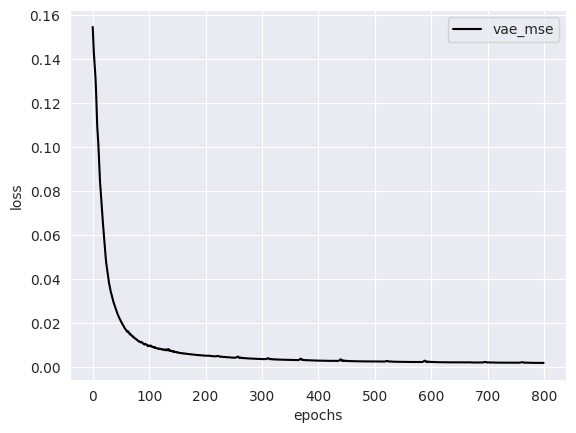

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
plt.plot(loss_of_cv, color="black",label="vae_mse")
#plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

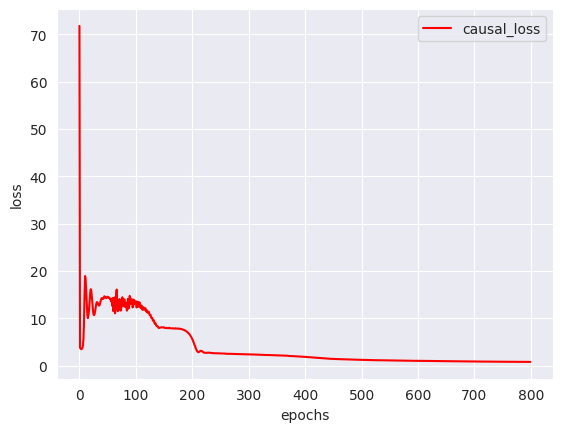

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
plt.plot(loss_of_cs, color="red",label="causal_loss")
#plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
d_l

<tf.Tensor: shape=(), dtype=float32, numpy=0.7658849954605103>

In [ ]:
loss_of_cv[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0018727779388427734>

In [ ]:
print(d_l, loss_of_cv[-1])

tf.Tensor(0.765885, shape=(), dtype=float32) tf.Tensor(0.0018727779, shape=(), dtype=float32)


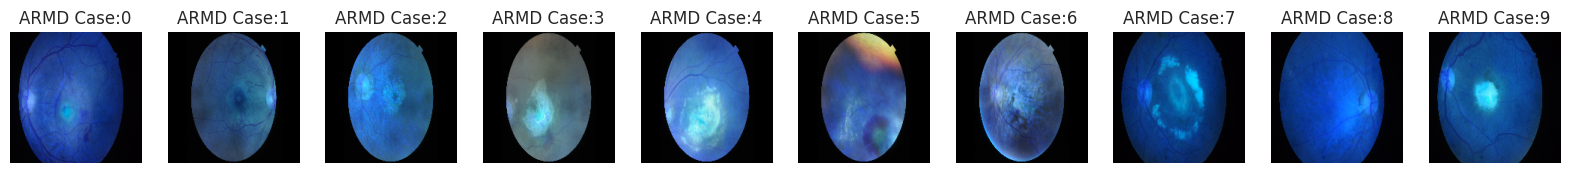

In [ ]:
#Original Images
tg = []
for i in range(len(y_nw2)):
  if y_nw2[i]==1:
    tg.append(i)
#len(tg)

fig = plt.figure(figsize=(20, 2))
rows = 1;columns=10
ax = []
tg2 = []
for j in [6,12,19,27,29,35,52,77,80,98]: #random images from AMD diagnosed retinal fundus set
  tg2.append(tg[j])

for i in range(columns*rows):
  ax.append(fig.add_subplot(rows,columns,i+1))
  ax[-1].set_title("ARMD Case:"+str(i))
  plt.axis("off")
  plt.imshow(X_nw2[tg2[i],:,:,:])

plt.show()

In [ ]:
#Generating images from CVAE
m1,l1 = CVAE.enc(X_nw2)
z11 = CVAE.reparam(m1,l1)
one1 = CVAE.dec(z11,sigmoid=True)

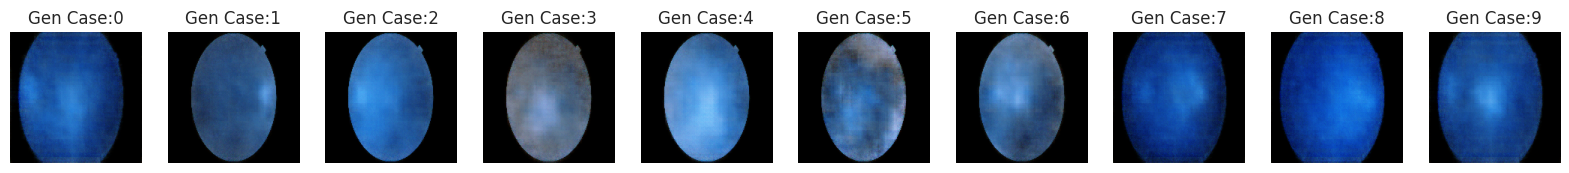

In [ ]:
#CVAE based generated images
fig = plt.figure(figsize=(20, 2)) #CVAE based generated AMD images for comparison
rows = 1;columns=10
ax = []

for i in range(columns*rows):
  ax.append(fig.add_subplot(rows,columns,i+1))
  ax[-1].set_title("Gen Case:"+str(i))
  plt.axis("off")
  plt.imshow(one1[tg2[i],:,:,:])
  #plt.grid()
plt.show()

In [ ]:
#Causal Disentanglement simulation.

#Generating images from CVAE
m1,l1 = CVAE.enc(X_nw2)
z11 = CVAE.reparam(m1,l1)
one1 = CVAE.dec(z11,sigmoid=True)

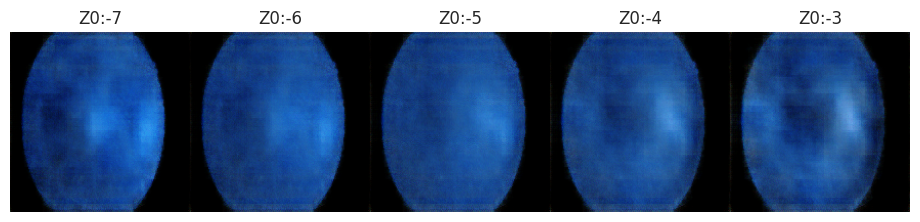

In [ ]:
#Disentanglement simulation
set1 = [-7,-6,-5,-4,-3] #For ZO
set2 = [-2,-1,0,1,2] #For Z4

fig3 = plt.figure(figsize=(10,2))
rows = 1; columns=5
ax3 = []

#Modifying only individual Z with other latent variables fixed. Ex) 221th image
for i in range(5):
  distangle = np.array(z11[221,:])
  distangle[0] = set1[i]
  distg = tf.reshape(tf.convert_to_tensor(distangle, dtype=tf.float32),[1,8])
  distg = CVAE.dec(distg, sigmoid=True)
  ax3.append(fig3.add_subplot(rows,columns,i+1))
  ax3[-1].set_title("Z0:"+str(set1[i]))
  plt.axis("off")
  plt.imshow(distg[0,:,:,:])

#Visualized Results
plt.tight_layout(pad=0.00)
plt.subplots_adjust(top = 1, bottom = 0, right = 2, left = 1.1, hspace = 0.5, wspace = 0)
plt.show()

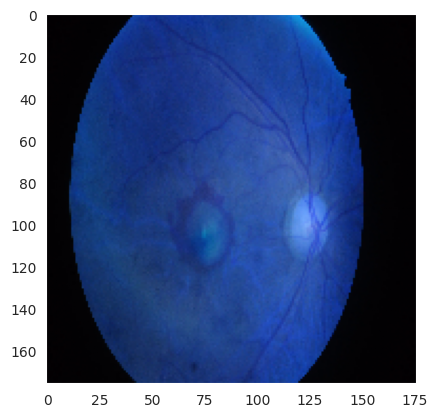

In [ ]:
plt.imshow(X_nw2[221,:,:,:])#Original image
plt.grid()
plt.show()

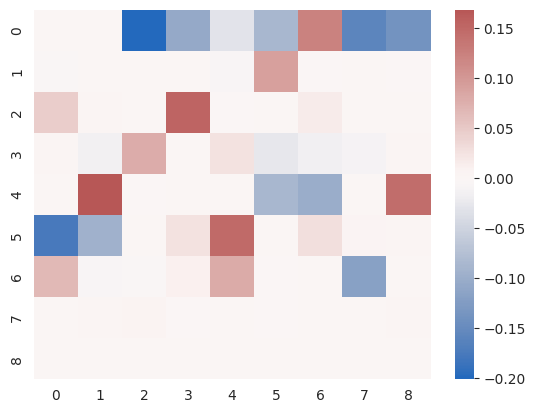

In [ ]:
#Resulted Weighted Adjacency matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(np.array(CVAE.GAE.DEC.weights[0]), cmap="vlag",center=0)
plt.show()

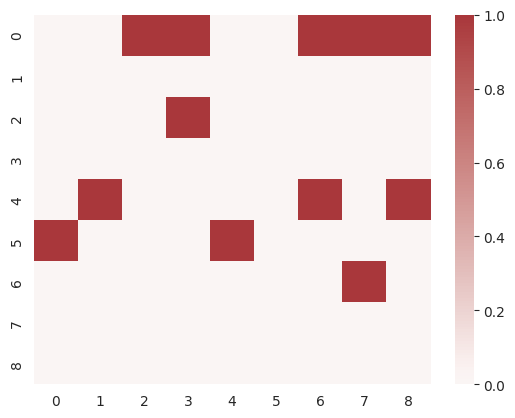

In [ ]:
#extracting only highly significant causal links from Weighted adjacency matrix under q=.15
q = 0.15
cd_num=100
candidate = np.linspace(0.01,0.2,100)
lt_d = lat_dim_ *1
d_2 = lt_d+1
results = []
i=0

while np.round(q*(d_2*d_2)) < cd_num:
    filtered = np.array(tf.where(tf.greater(np.abs(np.array(CVAE.GAE.DEC.weights[0])),candidate[i],0),1,0))
    cd_num = sum(sum(filtered))
    results.append(candidate[i])
    i += 1


#Returned binary adjacency matrix
sns.heatmap(filtered, cmap="vlag",center=0)
plt.show()

In [ ]:
#Visualizing extracted causal graph using networkx
import networkx as nx
dic = {}
for i in enumerate(['Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','status']):
  dic[i[0]] = i[1]

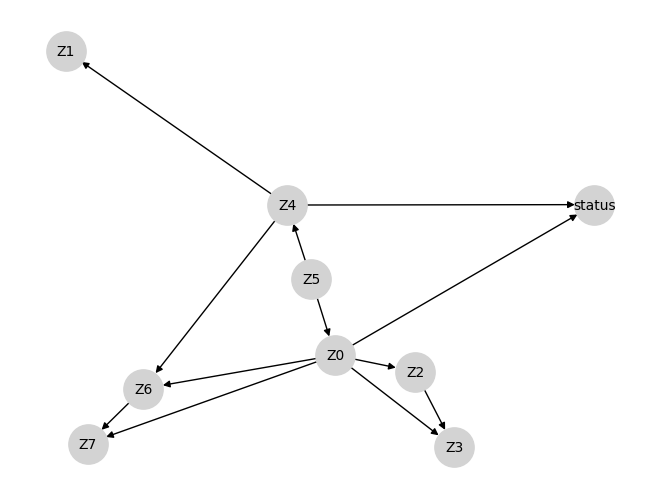

In [ ]:
np.random.seed(237)
filtered = np.array(filtered)*1
G = nx.from_numpy_array(filtered, create_using=nx.DiGraph())
nx.draw(G, with_labels=True, connectionstyle="arc, rad=0.2",node_size=0.8e+3,font_size=10, node_color="lightgray",labels=dic)

In [ ]:
import cdt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [ ]:
#Creating domain knowledge based Adjacency matrix for SHD computation.
ground = np.zeros(4*4).reshape(4,4)
ground[0,1] = ground[1,3] = ground[2,3] =1

In [ ]:
import networkx as nx
dic2 = {}
for i in enumerate(['neovascularization','hemorrhage','Druzen','ARMD']):
  dic2[i[0]] = i[1]

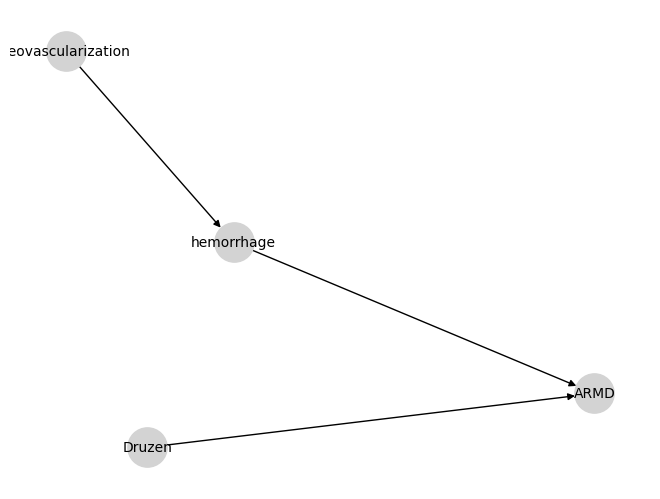

In [ ]:
#domain graph visualization
G2 = nx.from_numpy_array(ground, create_using=nx.DiGraph())
nx.draw(G2, with_labels=True, connectionstyle="arc, rad=0.3",node_size=0.8e+3,font_size=10, node_color="lightgray",labels=dic2)

In [ ]:
#Sub graph extraction based on criterion
filtered_2 = filtered[[5,4,0,8],:]
filtered_2 = filtered_2[:,[5,4,0,8]]

In [ ]:
#Computing Structural Hamming Distance
cdt.metrics.SHD(ground, filtered_2,double_for_anticausal=True) #SHD for deduced Causal Graph

1.0

In [ ]:
#Downstream task experiments: encoding train, validation, test data each for analysis based on CVAE.
tf.keras.utils.set_random_seed(321)
m_,l_ = CVAE.enc(X_n2)
z_tr = CVAE.reparam(m_,l_)
m_v,l_v = CVAE.enc(X_nv2)
z_v = CVAE.reparam(m_v,l_v)
m_ts,l_ts = CVAE.enc(X_nte2)
z_ts = CVAE.reparam(m_ts,l_ts)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [ ]:
#Fitting ML models
rf = RandomForestClassifier(n_estimators=100,class_weight="balanced",max_depth=10,random_state=321)
rf.fit(z_tr,y_n2)
gbm =GradientBoostingClassifier(n_estimators=100,random_state=321)
gbm.fit(z_tr,y_n2)
et = ExtraTreesClassifier(n_estimators=100,class_weight="balanced",max_depth=10,random_state=321)
et.fit(z_tr,y_n2)

ExtraTreesClassifier(class_weight='balanced', max_depth=10, random_state=321)

In [ ]:
print(f1_score(y_n2,rf.predict(z_tr)))
print(f1_score(y_n2,gbm.predict(z_tr)))
print(f1_score(y_n2,et.predict(z_tr)))

1.0
0.9583333333333334
0.9803921568627451


In [ ]:
print(accuracy_score(y_n2,rf.predict(z_tr)))
print(accuracy_score(y_n2,gbm.predict(z_tr)))
print(accuracy_score(y_n2,et.predict(z_tr)))

1.0
0.9840319361277445
0.9920159680638723


In [ ]:
print(classification_report(y_nte2,rf.predict(z_ts),digits=4))

              precision    recall  f1-score   support

           0     0.8506    0.9776    0.9097       134
           1     0.7273    0.2581    0.3810        31

    accuracy                         0.8424       165
   macro avg     0.7890    0.6178    0.6453       165
weighted avg     0.8275    0.8424    0.8104       165



In [ ]:
print(classification_report(y_nte2,gbm.predict(z_ts),digits=4))

              precision    recall  f1-score   support

           0     0.8526    0.9925    0.9172       134
           1     0.8889    0.2581    0.4000        31

    accuracy                         0.8545       165
   macro avg     0.8707    0.6253    0.6586       165
weighted avg     0.8594    0.8545    0.8201       165



In [ ]:
print(classification_report(y_nte2,et.predict(z_ts),digits=4))

              precision    recall  f1-score   support

           0     0.8699    0.9478    0.9071       134
           1     0.6316    0.3871    0.4800        31

    accuracy                         0.8424       165
   macro avg     0.7507    0.6674    0.6936       165
weighted avg     0.8251    0.8424    0.8269       165



In [ ]:
#DNN for predicting AMD
tf.keras.utils.set_random_seed(321321)
os.environ['TF_DETERMINISTIC_OPS']='1'
k3 = tf.keras.initializers.HeNormal(123)

md_c = Sequential([
    InputLayer(shape=(8,)),
    BatchNormalization(),
    Dense(units = 128, kernel_initializer=k3, activation="elu"),
    BatchNormalization(),
    Dense(units=64,kernel_initializer=k3,activation="elu"),
    BatchNormalization(),
    Dense(units=1,kernel_initializer=k3, activation="sigmoid")
    ])

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam
md_c.compile(optimizer=Adam(learning_rate=4e-4), loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,alpha=0.6,label_smoothing=0.3), metrics=["accuracy"])

In [ ]:
hist = md_c.fit(x=z_tr, y=y_n2,epochs=300,batch_size=200)

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6685 - loss: 0.0977
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6777 - loss: 0.0854
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6770 - loss: 0.0792
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6751 - loss: 0.0747
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6958 - loss: 0.0714
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7118 - loss: 0.0682
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7321 - loss: 0.0660
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7459 - loss: 0.0644
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7366 - loss: 0.0628 
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7507 - loss: 0.0616
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7582 - loss: 0.0607
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7680 - 

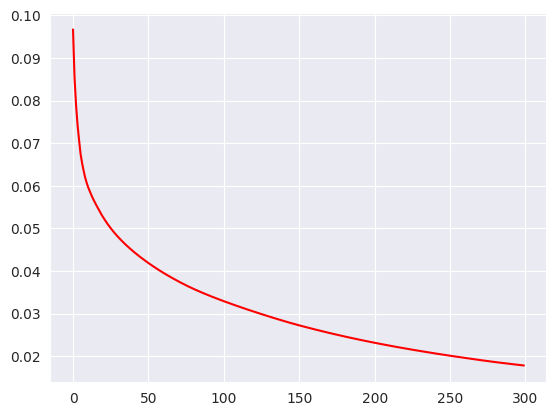

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
plt.plot(hist.history['loss'], color="red",label="loss")

In [ ]:
f1_score(y_n2,np.round(md_c.predict(z_tr)))#0.907..

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


0.9117647058823529

In [ ]:
accuracy_score(y_n2, np.round(md_c.predict(z_tr)))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


0.9640718562874252

In [ ]:
#Prediction results
prd = md_c.predict(z_ts)
prd1 = []
for i in range(len(y_nte2)):
  if prd[i] < 0.5:
    prd1.append(0)
  else:
    prd1.append(1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


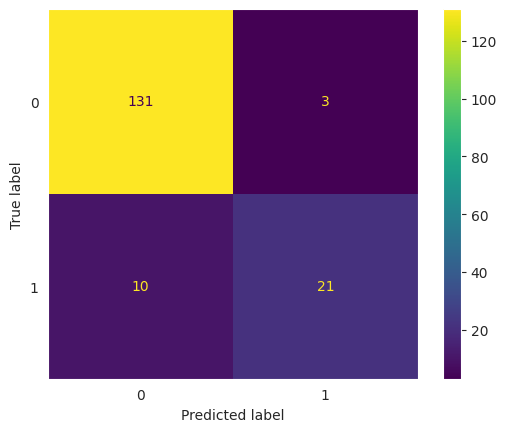

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
dis = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_nte2,prd1), display_labels=[0,1])
dis.plot()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_nte2,prd1,digits=4))

              precision    recall  f1-score   support

           0     0.9291    0.9776    0.9527       134
           1     0.8750    0.6774    0.7636        31

    accuracy                         0.9212       165
   macro avg     0.9020    0.8275    0.8582       165
weighted avg     0.9189    0.9212    0.9172       165



In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_nte2,md_c.predict(z_ts))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


0.9200770341839191

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


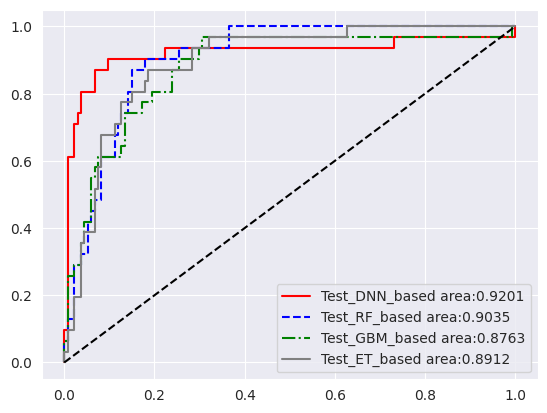

In [ ]:
#ROC AUC results
from sklearn.metrics import roc_auc_score, roc_curve

fpr1, tpr1, _1 = roc_curve(y_nte2, md_c.predict(z_ts))
fpr2, tpr2, _2 = roc_curve(y_nte2,rf.predict_proba(z_ts)[:,1])
fpr3, tpr3, _3 = roc_curve(y_nte2,gbm.predict_proba(z_ts)[:,1])
fpr4, tpr4, _4 = roc_curve(y_nte2,et.predict_proba(z_ts)[:,1])
plt.plot(fpr1,tpr1, label="Test_DNN_based"+" area:"+str(np.round(roc_auc_score(y_nte2,md_c.predict(z_ts)),4)),color="red")
plt.plot(fpr2,tpr2, label="Test_RF_based"+" area:"+str(np.round(roc_auc_score(y_nte2,rf.predict_proba(z_ts)[:,1]),4)),color="blue",linestyle="--")
plt.plot(fpr3,tpr3, label="Test_GBM_based"+" area:"+str(np.round(roc_auc_score(y_nte2,gbm.predict_proba(z_ts)[:,1]),4)),color="green",linestyle="-.")
plt.plot(fpr4,tpr4, label="Test_ET_based"+" area:"+str(np.round(roc_auc_score(y_nte2,et.predict_proba(z_ts)[:,1]),4)),color="gray",linestyle="-")
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),color="black",linestyle="--")
plt.legend()
#plt.grid()
plt.show()